In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iconcepts/Amazon Review data.xlsx
/kaggle/input/iconcepts/test iConcepts_reviews.xlsx


**Imports**

In [1]:
# Import necessary libraries and modules
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Loading Data and Models**

In [2]:
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')  # BERT for generating embeddings
sentiment_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Load training data (Amazon Review Data)
amazon_reviews = pd.read_excel('/kaggle/input/iconcepts/Amazon Review data.xlsx')  # Replace with the correct path

# Map sentiments to numeric labels (positive=0, negative=1, neutral=2)
amazon_reviews['sentiment'] = amazon_reviews['Sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenizing and Preparing Data**

In [3]:
# Tokenize data function
def tokenize_data(reviews):
    return tokenizer(reviews, padding=True, truncation=True, return_tensors='pt', max_length=512)

# Define a custom dataset class for BERT
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


**Training the Sentiment Model**

In [4]:
def train_model(train_reviews, train_sentiments, val_reviews, val_sentiments, fold=None):
    # Tokenize the data for this fold
    train_encodings = tokenize_data(train_reviews)
    val_encodings = tokenize_data(val_reviews)

    # Create dataset objects
    train_dataset = ReviewsDataset(train_encodings, train_sentiments)
    val_dataset = ReviewsDataset(val_encodings, val_sentiments)

    # Set up training arguments
    output_dir = f'./results_fold_{fold}' if fold else './results'
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="steps",
    )

    # Initialize Trainer
    trainer = Trainer(
        model=sentiment_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Save the model
    sentiment_model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)


**Cross-Validation with Training and Validation metrics on Amazon Reviews**

In [5]:
def cross_validate_model(k_folds=5):
    # Create KFold object
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Prepare the data
    reviews = amazon_reviews['Cleaned Review Description'].tolist()
    sentiments = amazon_reviews['sentiment'].tolist()

    # Store metrics for training and validation
    train_accuracy_scores, val_accuracy_scores = [], []
    train_precision_scores, val_precision_scores = [], []
    train_recall_scores, val_recall_scores = [], []
    train_f1_scores, val_f1_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(reviews, sentiments)):
        print(f"Training fold {fold+1}/{k_folds}...")
        
        # Split data into training and validation sets for this fold
        train_reviews = [reviews[i] for i in train_idx]
        val_reviews = [reviews[i] for i in val_idx]
        train_sentiments = [sentiments[i] for i in train_idx]
        val_sentiments = [sentiments[i] for i in val_idx]
        
        # Train the model on this fold
        train_model(train_reviews, train_sentiments, val_reviews, val_sentiments, fold=fold+1)
        
        # Evaluate on training set
        train_encodings = tokenize_data(train_reviews)
        train_predictions = []
        for i in range(len(train_encodings['input_ids'])):
            inputs = {key: train_encodings[key][i].unsqueeze(0).to(device) for key in train_encodings}
            with torch.no_grad():
                outputs = sentiment_model(**inputs)
                logits = outputs.logits
                predicted_class = torch.argmax(logits, dim=1).item()
            train_predictions.append(predicted_class)

        # Compute training metrics
        train_accuracy = accuracy_score(train_sentiments, train_predictions)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_sentiments, train_predictions, average='weighted')

        # Store training metrics
        train_accuracy_scores.append(train_accuracy)
        train_precision_scores.append(train_precision)
        train_recall_scores.append(train_recall)
        train_f1_scores.append(train_f1)

        # Evaluate on validation set
        val_encodings = tokenize_data(val_reviews)
        val_predictions = []
        for i in range(len(val_encodings['input_ids'])):
            inputs = {key: val_encodings[key][i].unsqueeze(0).to(device) for key in val_encodings}
            with torch.no_grad():
                outputs = sentiment_model(**inputs)
                logits = outputs.logits
                predicted_class = torch.argmax(logits, dim=1).item()
            val_predictions.append(predicted_class)

        # Compute validation metrics
        val_accuracy = accuracy_score(val_sentiments, val_predictions)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_sentiments, val_predictions, average='weighted')

        # Store validation metrics
        val_accuracy_scores.append(val_accuracy)
        val_precision_scores.append(val_precision)
        val_recall_scores.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f"Fold {fold+1} - Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    
    # Visualize the differences between training and validation
    plot_training_vs_validation_metrics(train_accuracy_scores, val_accuracy_scores, 'Accuracy')
    plot_training_vs_validation_metrics(train_precision_scores, val_precision_scores, 'Precision')
    plot_training_vs_validation_metrics(train_recall_scores, val_recall_scores, 'Recall')
    plot_training_vs_validation_metrics(train_f1_scores, val_f1_scores, 'F1-Score')

# Plot function
def plot_training_vs_validation_metrics(train_scores, val_scores, metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_scores) + 1), train_scores, label=f'Training {metric_name}', marker='o')
    plt.plot(range(1, len(val_scores) + 1), val_scores, label=f'Validation {metric_name}', marker='o')
    plt.title(f'Training vs Validation {metric_name} by Fold')
    plt.xlabel('Fold')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()


**Aspect Classification and Sentiment Prediction on Test Data**

In [6]:
def classify_aspect(review):
    aspect_keywords = {
    'concepts': ['concepts', 'understand', 'principle', 'theory', 'classification', 'learning', 'malocclusion'],
    'content': ['examples', 'chapter', 'section', 'structure', 'content', 'case studies', 'explanations'],
    'illustrations': ['images', 'pictures', 'figures', 'diagram', 'visual', 'animations', 'visualizations'],
    'text': ['text', 'writing', 'paragraph', 'wording', 'description', 'concise', 'definitions', 'summaries'],
    'video': ['videos', 'clips', 'watch', 'see', 'presentation', 'audiovisual', 'interactive'],
    'usability': ['easy to understand', 'easy to follow', 'simple', 'user-friendly', 'organized', 'accessible'],
    'efficiency': ['time efficiency', 'effective', 'succinct', 'concise', 'fast', 'efficient'],
    'interactivity': ['interactive', 'modules', 'sharing', 'annotations'],
    'accessibility': ['access', 'available', 'browser', 'online', 'internet', 'e-learning']
}


    review_lower = review.lower()
    for aspect, keywords in aspect_keywords.items():
        if any(keyword in review_lower for keyword in keywords):
            return aspect
    return None 

def predict_sentiment(review):
    inputs = tokenizer(review, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy().flatten()
        sentiment_logits = logits.cpu().numpy().flatten()
    sentiment_label = {0: 'positive', 1: 'negative', 2: 'neutral'}
    label = sentiment_label[predicted_class]
    return label, sentiment_logits, probabilities

def process_test_data(test_data):
    test_data['aspect'] = test_data['cleaned_review'].apply(classify_aspect)
    sentiment_results = test_data['cleaned_review'].apply(predict_sentiment)
    test_data['sentiment'], test_data['sentiment_logits'], test_data['sentiment_probabilities'] = zip(*sentiment_results)

    # Save the final test data with aspects, sentiments, logits, and softmax probabilities
    test_data.to_excel('./final_prediction.xlsx', index=False)

    print("Aspect classification and sentiment analysis on test data completed.")


**Visualization of Average Sentiment by Aspect**

In [7]:
def calculate_average_sentiment(test_data):
    # Convert sentiment_probabilities column into a DataFrame for easier processing
    probabilities_df = pd.DataFrame(test_data['sentiment_probabilities'].tolist(), columns=['positive', 'negative', 'neutral'])
    test_data = pd.concat([test_data, probabilities_df], axis=1)

    # Calculate average sentiment by aspect for both positive and negative sentiments
    average_sentiment_by_aspect_pos = test_data.groupby('aspect')['positive'].mean().reset_index()
    average_sentiment_by_aspect_neg = test_data.groupby('aspect')['negative'].mean().reset_index()

    return average_sentiment_by_aspect_pos, average_sentiment_by_aspect_neg

def plot_average_sentiment_by_aspect(average_sentiment_by_aspect_pos, average_sentiment_by_aspect_neg):
    # Plot average positive sentiment by aspect
    plt.figure(figsize=(10, 6))
    sns.barplot(x='aspect', y='positive', data=average_sentiment_by_aspect_pos, palette='viridis')
    plt.title('Average Positive Sentiment by Aspect')
    plt.ylabel('Average Positive Sentiment')
    plt.xlabel('Aspect')
    plt.xticks(rotation=45)
    plt.show()

    # Plot average negative sentiment by aspect
    plt.figure(figsize=(10, 6))
    sns.barplot(x='aspect', y='negative', data=average_sentiment_by_aspect_neg, palette='viridis')
    plt.title('Average Negative Sentiment by Aspect')
    plt.ylabel('Average Negative Sentiment')
    plt.xlabel('Aspect')
    plt.xticks(rotation=45)
    plt.show()


**Execution of Cross Validation**

Training fold 1/5...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,1.123200,1.148735
20,1.075600,1.060192
30,0.999800,0.992033
40,0.962600,0.942460
50,0.937900,0.885043
60,0.841800,0.809829
70,0.725900,0.745343
80,0.680900,0.680394
90,0.672200,0.609829
100,0.630300,0.560155


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 - Training Accuracy: 0.9645748987854251, Validation Accuracy: 0.9311740890688259
Training fold 2/5...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,0.139200,0.106351
20,0.133700,0.103943
30,0.237100,0.100420
40,0.143400,0.095976
50,0.168100,0.093228
60,0.139700,0.086564
70,0.134200,0.082725
80,0.092100,0.080600
90,0.157900,0.104838
100,0.099000,0.080003


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 - Training Accuracy: 0.9878542510121457, Validation Accuracy: 0.979757085020243
Training fold 3/5...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,0.039600,0.021446
20,0.081600,0.021218
30,0.039700,0.019911
40,0.046000,0.031554
50,0.050400,0.020454
60,0.031700,0.016487
70,0.019600,0.018011
80,0.022300,0.014803
90,0.024400,0.012388
100,0.050600,0.012183


Fold 3 - Training Accuracy: 0.9979757085020243, Validation Accuracy: 0.9959514170040485
Training fold 4/5...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,0.003100,0.003494
20,0.037200,0.001503
30,0.001900,0.001130
40,0.001800,0.000975
50,0.015100,0.000997
60,0.038600,0.000822
70,0.003100,0.000816
80,0.001300,0.000727
90,0.032300,0.000702
100,0.041400,0.001023


Fold 4 - Training Accuracy: 0.9969635627530364, Validation Accuracy: 1.0
Training fold 5/5...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
10,0.000400,0.030074
20,0.084400,0.029571
30,0.000400,0.026824
40,0.000400,0.025663
50,0.001200,0.025473
60,0.050600,0.024872
70,0.000800,0.024891
80,0.000700,0.025696
90,0.000500,0.026311
100,0.000400,0.026967


Fold 5 - Training Accuracy: 0.9969635627530364, Validation Accuracy: 0.9878542510121457


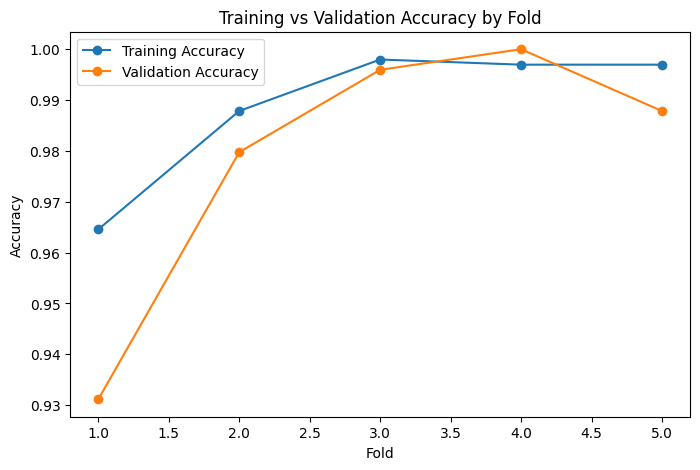

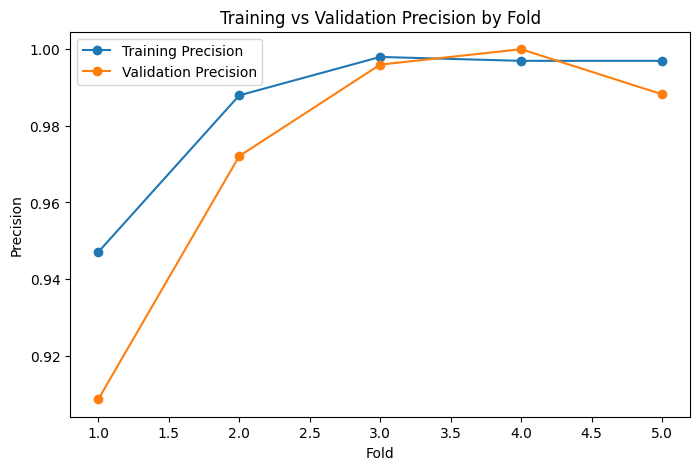

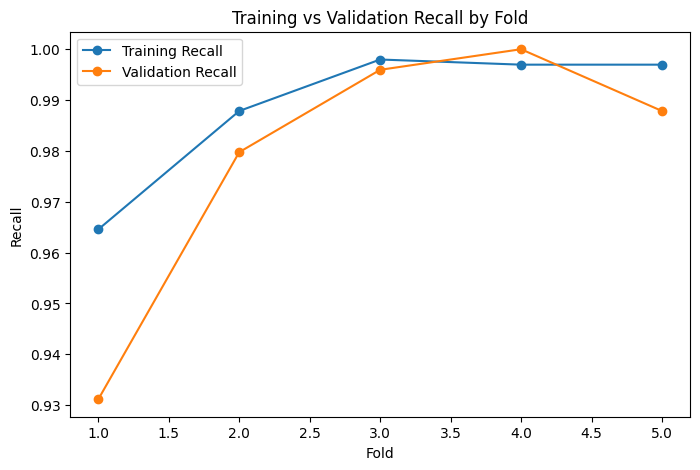

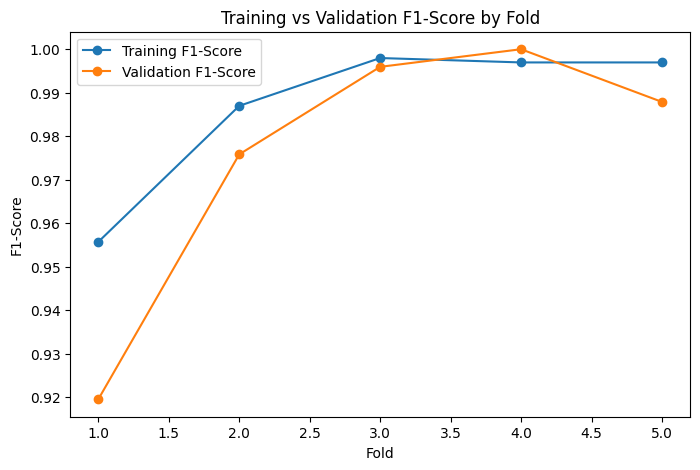

Aspect classification and sentiment analysis on test data completed.


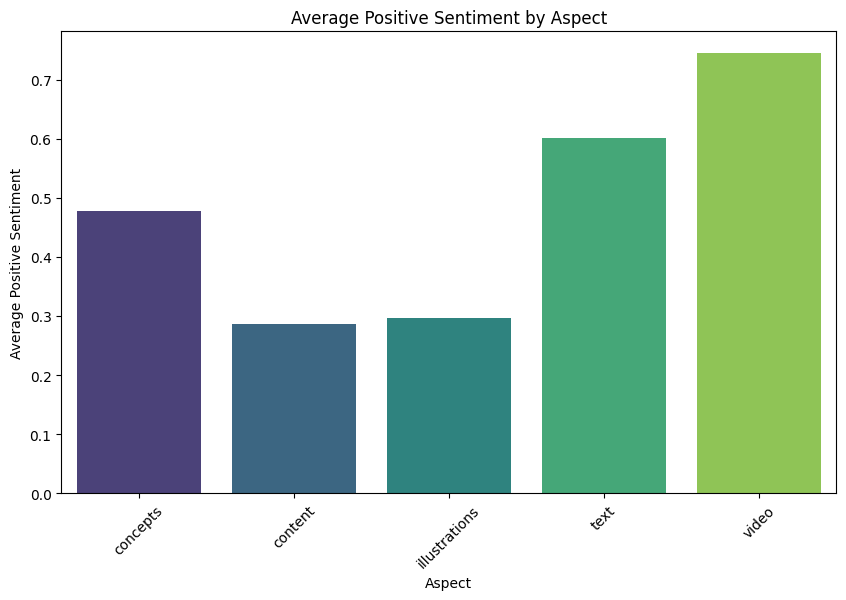

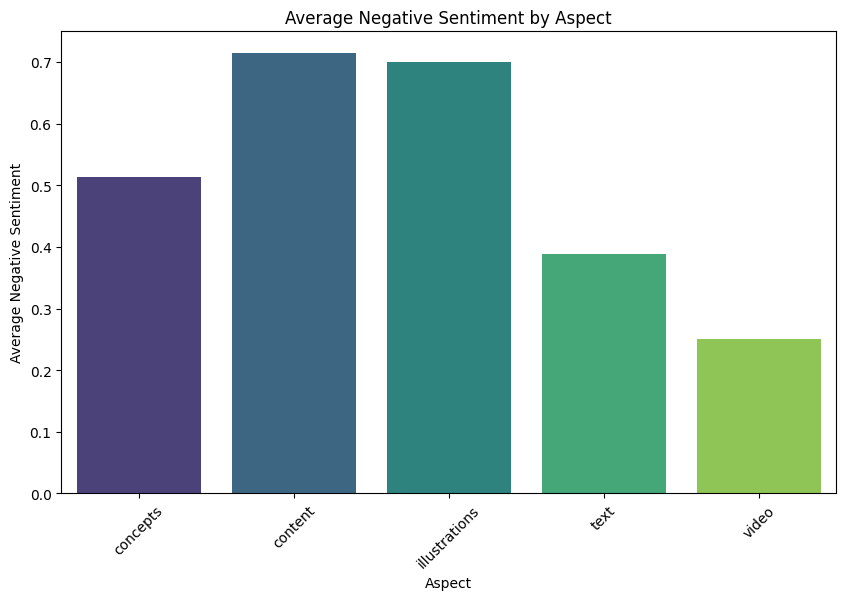

In [8]:
# Cross-validation to evaluate training vs validation metrics
cross_validate_model(k_folds=5)

# Load test data
test_data = pd.read_excel('/kaggle/input/iconcepts/test iConcepts_reviews.xlsx')  

# Process the test data for aspect classification and sentiment analysis
process_test_data(test_data)

# Calculate average sentiment by aspect
average_sentiment_by_aspect_pos, average_sentiment_by_aspect_neg = calculate_average_sentiment(test_data)

# Plot the average sentiment by aspect
plot_average_sentiment_by_aspect(average_sentiment_by_aspect_pos, average_sentiment_by_aspect_neg)


Overall Sentiment Distribution (%)
sentiment
negative    54.285714
positive    45.714286
Name: proportion, dtype: float64

Sentiment Distribution by Aspect (%)
sentiment        negative   positive
aspect                              
concepts        50.000000  50.000000
content         57.142857  42.857143
illustrations  100.000000        NaN
text            60.000000  40.000000
video           25.000000  75.000000

Aspect Count (Number of Reviews)
aspect
concepts         14
content           7
text              5
video             4
illustrations     3
Name: count, dtype: int64

Average Positive Sentiment by Aspect
          aspect  positive
0       concepts  0.532390
1        content  0.428382
2  illustrations  0.107367
3           text  0.400750
4          video  0.697409


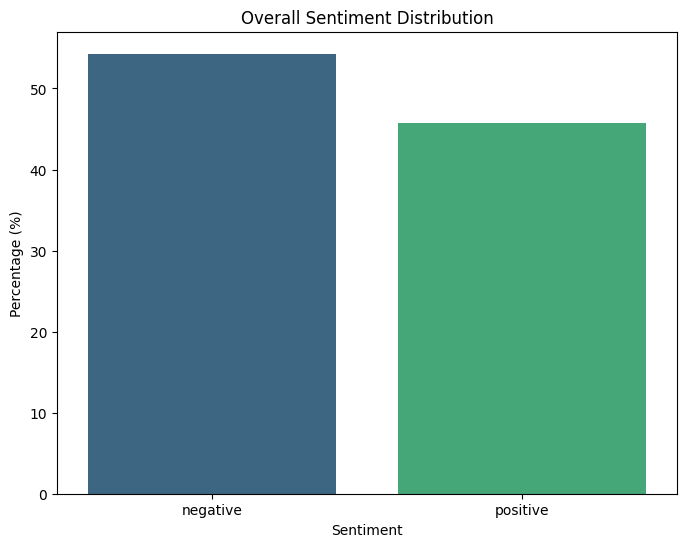

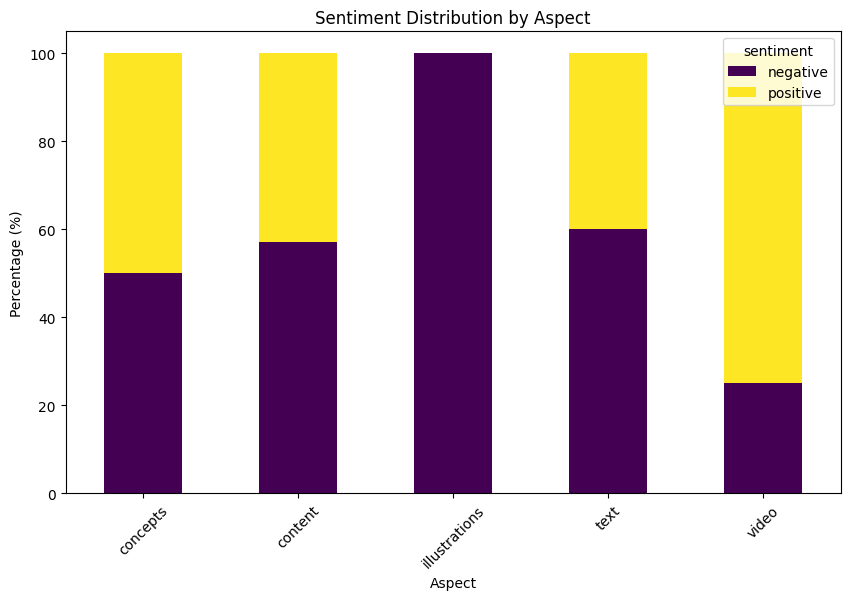

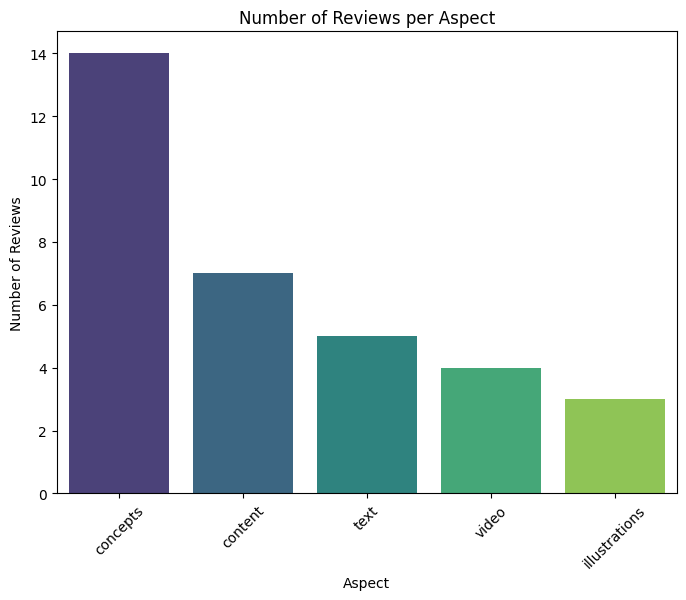

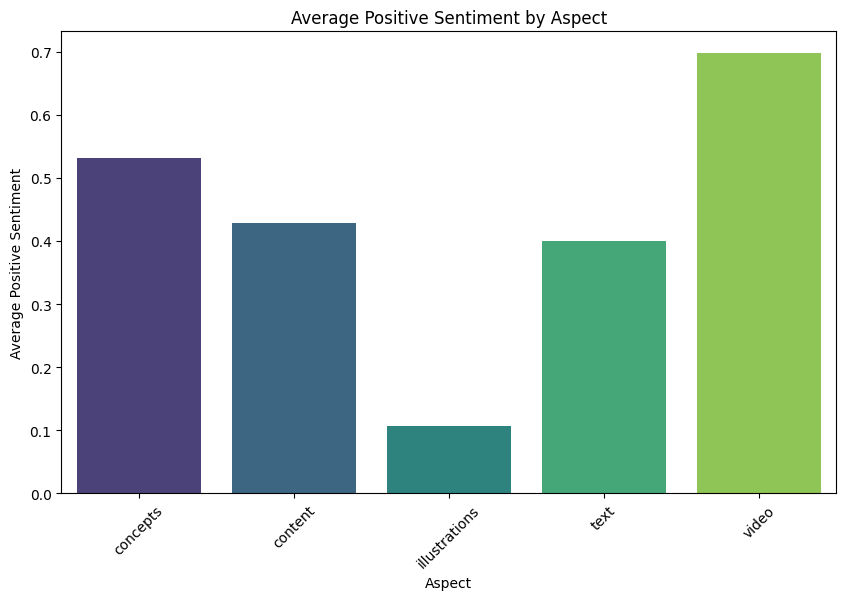

Aspect classification and sentiment analysis on test data completed with additional metrics.


In [15]:
def experiment(test_data):  
    # Step 1: Calculate overall sentiment distribution
    sentiment_distribution = test_data['sentiment'].value_counts(normalize=True) * 100
    print("\nOverall Sentiment Distribution (%)")
    print(sentiment_distribution)
    
    # Step 2: Calculate sentiment distribution by aspect
    sentiment_by_aspect = test_data.groupby('aspect')['sentiment'].value_counts(normalize=True).unstack() * 100
    print("\nSentiment Distribution by Aspect (%)")
    print(sentiment_by_aspect)
    
    # Step 3: Count the number of reviews classified into each aspect
    aspect_counts = test_data['aspect'].value_counts()
    print("\nAspect Count (Number of Reviews)")
    print(aspect_counts)
    
    # Step 4: Average sentiment score by aspect (using positive sentiment probability)
    probabilities_df = pd.DataFrame(test_data['sentiment_probabilities'].tolist(), columns=['positive', 'negative', 'neutral'])
    test_data = pd.concat([test_data, probabilities_df], axis=1)
    
    average_sentiment_by_aspect = test_data.groupby('aspect')['positive'].mean().reset_index()
    print("\nAverage Positive Sentiment by Aspect")
    print(average_sentiment_by_aspect)
    
    # Step 5: Visualize the distributions and averages
    
    # Plot overall sentiment distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='viridis')
    plt.title('Overall Sentiment Distribution')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Sentiment')
    plt.show()

    # Plot sentiment distribution by aspect
    sentiment_by_aspect.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Sentiment Distribution by Aspect')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Aspect')
    plt.xticks(rotation=45)
    plt.show()

    # Plot aspect count
    plt.figure(figsize=(8, 6))
    sns.barplot(x=aspect_counts.index, y=aspect_counts.values, palette='viridis')
    plt.title('Number of Reviews per Aspect')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Aspect')
    plt.xticks(rotation=45)
    plt.show()

    # Plot average positive sentiment by aspect
    plt.figure(figsize=(10, 6))
    sns.barplot(x='aspect', y='positive', data=average_sentiment_by_aspect, palette='viridis')
    plt.title('Average Positive Sentiment by Aspect')
    plt.ylabel('Average Positive Sentiment')
    plt.xlabel('Aspect')
    plt.xticks(rotation=45)
    plt.show()

    print("Aspect classification and sentiment analysis on test data completed with additional metrics.")

# Run the extended process
experiment(test_data)
